# Local Covid-19 Metrics

## Gather Datasets

In [6]:

# init
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pandas import DataFrame

# set parameters
days_back = 120

# get content from web APIs
us = requests.get('https://covidtracking.com/api/v1/us/daily.json')
us = us.text
us = pd.read_json(us)

pa = requests.get('https://covidtracking.com/api/v1/states/pa/daily.json')
pa = pa.text
pa = pd.read_json(pa)

nj = requests.get('https://covidtracking.com/api/v1/states/nj/daily.json')
nj = nj.text
nj = pd.read_json(nj)

# we can only get the past 7 days for bucks county with this API
bucks_data = requests.get('https://localcoviddata.com/covid19/v1/cases/newYorkTimes?zipCode=19067&daysInPast=7')
bucks_data = bucks_data.text
bucks_data = pd.read_json(bucks_data)
bucks_data = bucks_data.counties[0].get("historicData")
bucks_data = DataFrame (bucks_data,columns=['date','deathCt','positiveCt'])
bucks_data['date'] = pd.to_datetime(pd.Series(bucks_data['date']), format="%Y-%m-%d")

# derive positive and death for bucks
diff = bucks_data[['deathCt','positiveCt']].diff(periods=-1)
bucks = bucks_data.join(diff, lsuffix='_caller', rsuffix='_other')
bucks = bucks.rename(columns={'deathCt_caller':'death_total'
                      ,'positiveCt_caller':'positive_total'
                      ,'deathCt_other':'death'
                      ,'positiveCt_other':'positive'})


# positiveCt_caller	deathCt_other	positiveCt_other

# massage datasets

# make function for the covid tracking api since they are all the same
def clean_covidtracking_api_data(df):
    
    # get subset
    df = df[['date','positiveIncrease','totalTestResultsIncrease'
           ,'hospitalizedCurrently','death','deathIncrease','positive']]
    
    # Rename dataset columns
    df = df.rename(columns={'positiveIncrease':'positive'
                              ,'totalTestResultsIncrease': 'tests'
                              ,'hospitalizedCurrently': 'hospitalized'
                              ,'death': 'death_total'
                              ,'deathIncrease': 'death'
                              ,'positive': 'positive_total'})
    
    # Harmonize date column
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(pd.Series(df['date']), format="%Y%m%d")
    
    # Derived Columns
    # Positivity Rate
    positive = df.loc[:,['positive']].values[0:]
    tests = df.loc[:,['tests']].values[0:]
    df['pos_rate'] = positive / tests * 100

    # Death Rate
    deaths = df.loc[:,['death_total']].values[0:]
    positive = df.loc[:,['positive_total']].values[0:]
    df['death_rate'] = (deaths / positive) * 100
    df['death_rate_est'] = (deaths / (positive * 10)) * 100
    
    return df

# fix individual files
pa = clean_covidtracking_api_data(pa)
nj = clean_covidtracking_api_data(nj)
us = clean_covidtracking_api_data(us)

# Make compact summary dataset
a = pa[['date','positive','pos_rate','hospitalized']]
b = nj[['date','positive','pos_rate','hospitalized']]
c = bucks[['date','positive']]
d = a.set_index('date').join(b.set_index('date'), lsuffix='_pa', rsuffix='_nj')
# e = a.set_index('date').join(c.set_index('date'))

# todo: message bucks county dataset, fix date type, add + count delta



# todo: harmonize all four datasets

# todo: combine most important datapoints into one dataframe for all four entities

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


In [8]:
e = d.set_index('date').join(c.set_index('date'))


KeyError: "None of ['date'] are in the columns"

In [45]:
bucks
# change political entity dataset to select visualizations
# (stopgap for now until we have better organized data)

# political_entity = pa

# view what we have for bucks


,date,deathCt,positiveCt
0,2020-08-05,580,7085
1,2020-08-04,580,7056
2,2020-08-03,579,7020
3,2020-08-02,579,6995
4,2020-08-01,578,6959
5,2020-07-31,578,6902


In [3]:

display(political_entity.loc[[0,1,2,3,4,5,6], ['date','positive','tests','pos_rate']])


,date,positive,tests,pos_rate
0,2020-08-06,807,15526,5.197733
1,2020-08-05,705,13196,5.342528
2,2020-08-04,854,14960,5.708556
3,2020-08-03,565,12000,4.708333
4,2020-08-02,654,12247,5.340083
5,2020-08-01,888,15450,5.747573
6,2020-07-31,970,16935,5.727783


## Show Hospital Rates

In [13]:

display(political_entity.loc[[0,1,2,3,4,5,6], ['date','hospitalized','death','death_rate','death_rate_est']])


,date,hospitalized,death,death_rate,death_rate_est
0,20200805,639.0,12,6.260262,0.626026
1,20200804,656.0,23,6.288204,0.628820
2,20200803,585.0,0,6.315098,0.631510
3,20200802,564.0,5,6.346509,0.634651
4,20200801,579.0,15,6.378834,0.637883
5,20200731,522.0,13,6.416000,0.641600
6,20200730,756.0,14,6.460325,0.646033


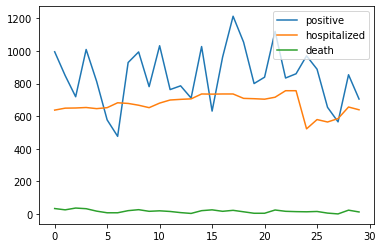

In [14]:

subset_df = political_entity.loc[:,['positive']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'positive')

subset_df = political_entity.loc[:,['hospitalized']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'hospitalized')

subset_df = political_entity.loc[:,['death']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'death')

plt.legend()
plt.show()


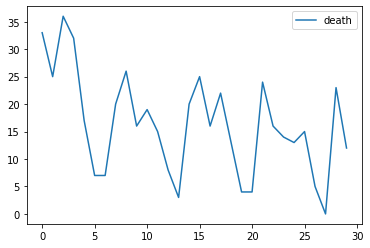

In [15]:
subset_df = political_entity.loc[:,['death']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'death')

plt.legend()
plt.show()

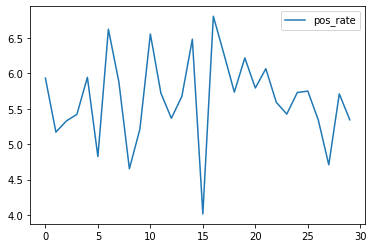

In [16]:
subset_df = political_entity.loc[:,['pos_rate']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'pos_rate')

plt.legend()
plt.show()